## **Layer.ai Air Quality Prediction Challenge**


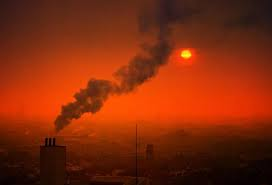

## **Install Layer**

In [31]:
%%capture
!pip install -U layer

# **UTILS**

In [62]:
import layer
from layer.decorators import dataset,model, pip_requirements

In [63]:
import os
import random
import sklearn
import datetime
import numpy as np
import pandas as pd 
import xgboost as xgb
from sklearn import metrics
from google.colab import files
from sklearn.model_selection import train_test_split


from sklearn.cluster import KMeans
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.simplefilter('ignore')

In [64]:
## Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
## ------------------- 
SEED = 47
seed_everything(SEED)

In [65]:
print(f"Numpy version=={np.__version__}")
print(f"Pandas version=={pd.__version__}")
print(f"xgboost version=={xgb.__version__}")
print(f"sklearn version=={sklearn.__version__}")

Numpy version==1.21.6
Pandas version==1.3.5
xgboost version==0.90
sklearn version==1.0.2


In [66]:
class CFG:
  
  SEED = 47

  params_xgb = {
            'gpu_id': 0, 
            #'n_gpus': 2, 
            'objective': 'reg:squarederror', 
            'eval_metric': 'rmse', 
            'booster': 'gbtree', 
            'n_estimators': 6000, 
            'tree_method': 'gpu_hist', 
            'grow_policy': 'lossguide', 
            'max_depth': 8, 
           'learning_rate': 0.01, 
            'max_bin': 90, #
            'max_leaves': 90, #
            'reg_alpha': 8, 
            'reg_lambda': 20, 
            'subsample': 0.8}

# **Login to layer**

In [6]:
layer.login()

Please open the following link in your web browser. Once logged in, copy the code and paste it here.
https://app.layer.ai/oauth/authorize?response_type=code&code_challenge=BUiwToCKr48slQbjTN0eF13O3MCkD4gVCoZjMWme9cg&code_challenge_method=S256&client_id=0STDdcnpK48P8A429EAAn93WNuLmViLR&redirect_uri=https://app.layer.ai/oauth/code&scope=offline_access&audience=https://app.layer.ai
Code: OzCR_iqDNqV_1IKWbV_WcedaSc486wPER9Q0t81WT8hxG
Successfully logged into https://app.layer.ai


# **Create a Layer project**

In [7]:
layer.init("Air_Quality_Hackathon")

Your Layer project is here: https://app.layer.ai/sodiq_damilola/Air_Quality_Hackathon

# **Fetch the datasets as Pandas DataFrames**

In [37]:
sample_submission = layer.get_dataset("zindi/air-quality/datasets/sample_submission").to_pandas()
test_df = layer.get_dataset("zindi/air-quality/datasets/test").to_pandas()
train_df = layer.get_dataset("zindi/air-quality/datasets/train").to_pandas()

Output()

Output()

Output()

In [38]:
df = pd.concat([train_df.drop("pm2_5", axis = 1), test_df]).reset_index(drop = True)

In [39]:
dropCol = (df.isnull().sum()/len(df))[(df.isnull().sum()/len(df)).gt(0.65)].index.to_list()

In [40]:
train_df = train_df.drop(dropCol, axis = 1).reset_index(drop = True)
test_df = test_df.drop(dropCol, axis = 1).reset_index(drop = True)

# **Data Preprocessing**

In [41]:
class ProcessData:
  
  def process(self,train,test) :

    ID_COL, TARGET_COL = 'ID', 'pm2_5'
    train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d')
    test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')

    train["train"] = 1
    test["train"] = 0

    df = pd.concat([train, test]).reset_index(drop=True)
    df = df.sort_values('date').reset_index(drop=True)

    engFeature = [x for x in df.columns if "angle" not in x if x not in  ["date", "ID", "device", "site_latitude", "site_longitude","pm2_5", "train"]]
    engFeature = [x for x in engFeature if "height" not in x if "depth" not in x if "altitude" not in x]

    FEAT = [x for x in df.columns if x not in ["ID", "date", "device", "site_latitude","site_longitude", "humidity","pm2_5"]]


    df["NoMissingVal"] = df.isnull().sum(axis = 1)

    it_imputer = IterativeImputer(max_iter = 10, random_state = 42)
    df[FEAT] = it_imputer.fit_transform(df[FEAT])

    for col in engFeature:
      df[f"{col}_bin_10"] = pd.qcut(df[col], q = 10, labels = [1,2,3,4,5,6,7,8,9,10]).astype(int)
   
    features = [c for c in df.columns if c not in ['ID', 'date', 'pm2_5']]
    df['device_freq'] = df['device'].map(df['device'].value_counts())
    #########################################################################################################################################

    for i in range(1, 10):
      df[f'target_previous_{i}'] = df[TARGET_COL].shift(i)
      df[f'target_next_{i}'] = df[TARGET_COL].shift(-i)

    for i in range(1, 5):
      df[f'target_prev_exp_{i}'] = df[TARGET_COL].shift(i).expanding().mean()

    for i in range(125, 135):
      df[f'target_previous_{i}'] = df[TARGET_COL].shift(i)

    ##############################################################################################################################################
    # ----------------------------------------------------------------------------------------------
    # ROLLING AGGREGATE FEATURES BASED ON DEVICE
    # ----------------------------------------------------------------------------------------------
    for roll in [3, 5, 7]:
      tempdfMean = df.rolling(roll).mean()[engFeature]
      tempdfVar = df.rolling(roll).var()[engFeature]
      for col in engFeature:
        df[f"{col}_rolling_mean_{roll}"] = tempdfMean[col].values
        df[f"{col}_rolling_var_{roll}"] = tempdfVar[col].values

    for i in range(1, 12):
      tmp = df[engFeature].shift(i)
      tmp_diff_prev = df[engFeature] - tmp
      tmp.columns = [c + f'_prev_{i}' for c in tmp.columns]
      tmp_diff_prev.columns = [c + f'_prev_diff_{i}' for c in tmp_diff_prev.columns]
      df = pd.concat([df, tmp, tmp_diff_prev], axis=1)
      
      tmp = df[engFeature].shift(-i)
      tmp_diff_next = df[engFeature] - tmp
      tmp.columns = [c + f'_next_{i}' for c in tmp.columns]
      tmp_diff_next.columns = [c + f'_next_diff_{i}' for c in tmp_diff_next.columns]
      df = pd.concat([df, tmp, tmp_diff_next], axis=1)

    for i in range(1, 3):
      tmp = df[engFeature].shift(i).expanding().mean()
      tmp_diff_prev = df[engFeature] - tmp
      tmp.columns = [c + f'_prev_exp_{i}' for c in tmp.columns]
      tmp_diff_prev.columns = [c + f'_prev_exp_diff_{i}' for c in tmp_diff_prev.columns]
      df = pd.concat([df, tmp, tmp_diff_prev], axis=1)
      
      tmp = df[engFeature].shift(-i).expanding().mean()
      tmp.columns = [c + f'_next_exp_{i}' for c in tmp.columns]
      tmp_diff_next.columns = [c + f'_next_exp_diff_{i}' for c in tmp_diff_next.columns]
      df = pd.concat([df, tmp, tmp_diff_next], axis=1)

    #####################################################################################################

    timeFeatures = ['day', 'month', 'week', 'dayofweek']
    for attr in timeFeatures:
          df[attr] = getattr(df['date'].dt, attr)

    for timeFeat in ['month', 'week', 'dayofweek', 'device']:
      tempdfMean = df.groupby(timeFeat).mean()[engFeature].to_dict()
      tempdfMedian = df.groupby(timeFeat).median()[engFeature].to_dict()
      tempdfStd = df.groupby(timeFeat).std()[engFeature].to_dict()
      tempdfVar = df.groupby(timeFeat).var()[engFeature].to_dict()
      for col in engFeature:
        df[f"{col}_by_{timeFeat}_mean"] = df[timeFeat].map(tempdfMean[col])
        df[f"{col}-{timeFeat}_mean"] = df[col] - df[f"{col}_by_{timeFeat}_mean"]
        df[f"{col}/{timeFeat}_mean"] = df[col] / df[f"{col}_by_{timeFeat}_mean"]

        df[f"{col}_by_{timeFeat}_median"] = df[timeFeat].map(tempdfMedian[col])
        df[f"{col}-{timeFeat}_median"] = df[col] - df[f"{col}_by_{timeFeat}_median"]
        df[f"{col}/{timeFeat}_median"] = df[col] / df[f"{col}_by_{timeFeat}_median"]

        df[f"{col}_by_{timeFeat}_std"] = df[timeFeat].map(tempdfStd[col])
        df[f"{col}-{timeFeat}_std"] = df[col] - df[f"{col}_by_{timeFeat}_std"]
        df[f"{col}/{timeFeat}_std"] = df[col] / df[f"{col}_by_{timeFeat}_std"]

        df[f"{col}_by_{timeFeat}_var"] = df[timeFeat].map(tempdfVar[col])
        df[f"{col}-{timeFeat}_var"] = df[col] - df[f"{col}_by_{timeFeat}_var"]
        df[f"{col}/{timeFeat}_var"] = df[col] / df[f"{col}_by_{timeFeat}_var"]

    ################################################################################################################################
    df.fillna(df.groupby(['device'], as_index=False).mean(), inplace=True)
    df.fillna(df.mean(), inplace=True)
    # ----------------------------------------------------------------------------------------------
    # ANGLE FEATURES
    # ----------------------------------------------------------------------------------------------
    angleFeat = [x for x in df.columns if "angle" in x]
    df[angleFeat] = df[angleFeat].apply(lambda x : np.radians(x))
    ################################################################################################################################
    for cluster in [10,15,25,35]:
      kmeans = KMeans(n_clusters=cluster)
      kmeans.fit(df[engFeature])
      df[f"Cluster_{cluster}"] = kmeans.predict(df[engFeature])
    ################################################################################################################################

    # Get our New Train,Test
    features = [x for x in df.columns if x not in ["ID", "date", "device","pm2_5","train"]]
    train = df[df["train"].eq(1)].drop(["train"], axis = 1).reset_index(drop=True)
    test = df[df["train"].eq(0)].drop(["train"], axis = 1).reset_index(drop=True)
    target = train["pm2_5"]
    test_ID = test["ID"]

    return train[features], test[features], test_ID, target

In [42]:
processor = ProcessData()
train_data, test_data, testID, target= processor.process(train_df , test_df)

In [43]:
train_data.head()

,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_surface_albedo_by_device_std,Cloud_surface_albedo-device_std,Cloud_surface_albedo/device_std,Cloud_surface_albedo_by_device_var,Cloud_surface_albedo-device_var,Cloud_surface_albedo/device_var,Cluster_10,Cluster_15,Cluster_25,Cluster_35
0,0.059604,32.46032,0.846583,22.641667,-0.000251,0.527936,-0.000133,0.116888,-1.716240,0.916533,...,0.063722,0.143113,3.245908,0.00406,0.202775,50.938735,5,0,3,1
1,0.059604,32.46032,0.783833,24.325000,-0.000132,0.562716,-0.000074,0.023798,-1.757054,0.464903,...,0.063722,0.177771,3.789799,0.00406,0.237432,59.474133,8,5,6,22
2,0.059604,32.46032,0.741972,25.725000,-0.000169,0.550671,-0.000093,0.030852,1.334801,0.204861,...,0.063722,0.157682,3.474534,0.00406,0.217343,54.526617,8,5,13,2
3,0.059604,32.46032,0.748049,24.607986,-0.000286,0.669683,-0.000192,0.000000,1.285022,0.763453,...,0.063722,0.175838,3.759470,0.00406,0.235500,58.998172,2,8,7,0
4,0.059604,32.46032,0.735576,24.857639,-0.000120,0.656247,-0.000079,0.010367,1.250467,1.087169,...,0.063722,0.090756,2.424254,0.00406,0.150417,38.044334,8,5,13,2


In [44]:
test_data.head()

,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_surface_albedo_by_device_std,Cloud_surface_albedo-device_std,Cloud_surface_albedo/device_std,Cloud_surface_albedo_by_device_var,Cloud_surface_albedo-device_var,Cloud_surface_albedo/device_var,Cluster_10,Cluster_15,Cluster_25,Cluster_35
0,0.289040,32.589580,0.792427,23.349306,0.000149,0.874902,0.000129,0.237890,1.315588,0.431532,...,0.047046,0.178045,4.784459,0.002213,0.222877,101.696956,1,10,1,29
1,0.381576,32.647109,0.877986,21.642014,-0.000306,0.811054,-0.000248,0.242543,1.316665,0.418310,...,0.046494,0.188176,5.047314,0.002162,0.232509,108.558039,6,12,11,33
2,0.357987,32.584100,0.870479,22.788542,0.036031,0.728489,0.025366,0.521898,1.315858,0.428126,...,0.046629,0.192009,5.117767,0.002174,0.236464,109.754222,6,4,20,5
3,0.379562,32.553714,0.887281,21.315436,0.036012,0.737149,0.025350,0.633315,1.315396,0.433266,...,0.047230,0.218508,5.626453,0.002231,0.263508,119.128183,6,4,20,5
4,0.343898,32.587226,0.831451,21.795139,0.036046,0.711347,0.025380,0.451363,1.315855,0.428226,...,0.042796,0.190256,5.445622,0.001832,0.231221,127.244959,6,4,20,33


In [45]:
train_data.shape, test_data.shape

((9923, 2558), (4254, 2558))

# **Feature Selection**

In [46]:
featureSelector = xgb.XGBRegressor(**CFG.params_xgb, random_state= 47)
featureSelector.fit(train_data, target)

featImp = pd.DataFrame(featureSelector.feature_importances_, index = train_data.columns, columns = ["Imp"]).sort_values("Imp", ascending = False)
dropCol = featImp[featImp["Imp"].eq(0)].index 
newFeat = [x for x in train_data.columns if x not in dropCol]

In [53]:
len(newFeat)

2355

# **XGBOOST Model  Functions**

In [60]:
train_X,  test_X,  train_y, test_y = train_test_split(train_data, target, test_size = 0.2, random_state = 47)

In [61]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((7938, 2558), (7938,), (1985, 2558), (1985,))

In [71]:
test_data[newFeat]

,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_surface_albedo/device_median,Cloud_surface_albedo_by_device_std,Cloud_surface_albedo-device_std,Cloud_surface_albedo/device_std,Cloud_surface_albedo-device_var,Cloud_surface_albedo/device_var,Cluster_10,Cluster_15,Cluster_25,Cluster_35
0,0.289040,32.589580,0.792427,23.349306,0.000149,0.874902,0.000129,0.237890,1.315588,0.431532,...,0.881086,0.047046,0.178045,4.784459,0.222877,101.696956,1,10,1,29
1,0.381576,32.647109,0.877986,21.642014,-0.000306,0.811054,-0.000248,0.242543,1.316665,0.418310,...,0.843127,0.046494,0.188176,5.047314,0.232509,108.558039,6,12,11,33
2,0.357987,32.584100,0.870479,22.788542,0.036031,0.728489,0.025366,0.521898,1.315858,0.428126,...,0.914043,0.046629,0.192009,5.117767,0.236464,109.754222,6,4,20,5
3,0.379562,32.553714,0.887281,21.315436,0.036012,0.737149,0.025350,0.633315,1.315396,0.433266,...,0.967153,0.047230,0.218508,5.626453,0.263508,119.128183,6,4,20,5
4,0.343898,32.587226,0.831451,21.795139,0.036046,0.711347,0.025380,0.451363,1.315855,0.428226,...,0.879329,0.042796,0.190256,5.445622,0.231221,127.244959,6,4,20,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4249,0.356400,32.573000,0.864569,20.422222,0.029356,0.666222,0.020661,0.671931,1.336283,0.185939,...,0.872841,0.046315,0.186780,5.032817,0.230950,108.664675,6,12,11,33
4250,0.332609,32.610047,0.864576,20.440278,0.029363,0.669598,0.020671,0.541930,1.336768,0.180411,...,0.884664,0.038442,0.180793,5.702949,0.217757,148.350380,6,4,20,5
4251,0.289040,32.589580,0.858764,21.663043,0.029339,0.660493,0.020653,0.630158,1.336495,0.183697,...,0.849909,0.047046,0.170080,4.615163,0.214913,98.098436,2,4,0,27
4252,0.298750,32.615000,0.855688,20.968403,0.029337,0.643278,0.020650,0.605828,1.336521,0.183456,...,0.838599,0.044345,0.170132,4.836532,0.212511,109.065250,6,4,20,33


In [72]:
@model("XGBOOSTS_MODEL_SINGLE_FirstSimple")
@pip_requirements(packages=["xgboost==0.90","sklearn==1.0.2","numpy==1.21.6", "pandas==1.3.5"])
def train_xgb():
    import numpy as np
    import pandas as pd 
    import xgboost as xgb
    from sklearn import metrics

    params_xgb = CFG.params_xgb
    features = newFeat
    X = train_X[features]
    val_X = test_X[features]
    y = train_y
    val_y = test_y
    X_test = test_data[features]
    
    layer.log({"Features size": len(features)})
    layer.log({"Train_shape": X.shape[0]})
    layer.log({"Test_shape": X_test.shape[0]})
    layer.log({"SEED": CFG.SEED})
    layer.log({"XGBoost Parameters" : params_xgb})

    regressor_xgb = xgb.XGBRegressor(**params_xgb , random_state= 47)
    regressor_xgb.fit(X, y, 
              eval_set=[(val_X, val_y)], 
              verbose=200, 
              early_stopping_rounds=150)

    predictions = regressor_xgb.predict(X_test)
    predctions_df = pd.DataFrame(predictions,columns=['Predicted pm2_5'])

    layer.log({"Sample predictions":predctions_df.head(100)})
    layer.log({'Mean Absolute Error':metrics.mean_absolute_error(test_y, regressor_xgb.predict(val_X))})
    layer.log({'Mean Squarred Error': metrics.mean_squared_error(test_y, regressor_xgb.predict(val_X))})
    layer.log({'Root Mean Squared Error': np.sqrt(metrics.mean_squared_error(test_y, regressor_xgb.predict(val_X)))})

    FILE_NAME_ = 'SingleXGBoostModel1_Simple.csv'
    sub_xgb = pd.DataFrame()
    sub_xgb["ID"] = testID
    sub_xgb["pm2_5"] = predictions
    sub_xgb.to_csv(FILE_NAME_, index=False)
    files.download(FILE_NAME_)

    return regressor_xgb

In [73]:
xgbmodel = train_xgb()

Output()

[0]	validation_0-rmse:63.2091
Will train until validation_0-rmse hasn't improved in 150 rounds.
[200]	validation_0-rmse:19.7673
[400]	validation_0-rmse:15.5866
[600]	validation_0-rmse:14.8487
[800]	validation_0-rmse:14.5737
[1200]	validation_0-rmse:14.3684
[1400]	validation_0-rmse:14.3221
[1600]	validation_0-rmse:14.2903
[1800]	validation_0-rmse:14.2671
[2000]	validation_0-rmse:14.2481
[2200]	validation_0-rmse:14.2385
[2400]	validation_0-rmse:14.2296
[2600]	validation_0-rmse:14.2233
[2800]	validation_0-rmse:14.2162
[3000]	validation_0-rmse:14.2094
[3200]	validation_0-rmse:14.2071
[3400]	validation_0-rmse:14.205
[3600]	validation_0-rmse:14.2045
[3800]	validation_0-rmse:14.2028
[4000]	validation_0-rmse:14.2027
[4200]	validation_0-rmse:14.2025
[4600]	validation_0-rmse:14.2005
[4800]	validation_0-rmse:14.1998
[5000]	validation_0-rmse:14.199
Stopping. Best iteration:
[4941]	validation_0-rmse:14.1989



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>